In [1]:
import numpy as np
import pandas as pd
import os
from pymatgen import MPRester
import re
import time

In the above cell all imports are handled.
<br>`from pymatgen import MPRester` is used as an API tool to download the formula and bandwidth of many catalyst

In [2]:
exclude = ['O', 'H', 'He', 'Ne', 'Ar', 'As', 'Se', 'Kr', 'Tc', 'Xe', 'Pm', 'Hf', 'Os', 'Ir', 'Hg', 'Tl', 'Ac', 'Pa', 'U', 'Np', 'Pu']
include = ['Ag', 'Al', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca', 'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'Ho', 'I', 'In', 'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni', 'P', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re', 'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Si', 'Sm', 'Sn', 'Sr', 'Ta', 'Tb', 'Te', 'Th', 'Ti', 'Tm', 'V', 'W', 'Y', 'Yb', 'Zn', 'Zr']
cloumn_order = include + ['band_gap']

`exclude`: Catalysts with these elements will be excludet in the dataset.
<br>`include`: Catalysts with these elements will be includuet in the dataset.
<br>`cloumn_order` This list will be used to order the columns in the dataset.

In [3]:
m = MPRester('ifLyENSM2ZCJUWrl') 
data = m.query(criteria={"elements": {"$nin": exclude}, "nelements": {"$lt": 9}, "band_gap": {"$gt": 1e-4}}, properties=["pretty_formula", "band_gap"])

`m = MPRester('ifLyENSM2ZCJUWrl') ` builds a connection to the online database and 
<br>`data = m.query(...)` downloads the formula and band_gap of the catalysts

In [4]:
def handle_parentheses(formula):
    paranthesis_content = formula[formula.find("(")+1:formula.find(")")]
    while paranthesis_content != formula[:-1]:
        faktor = int(formula[formula.find(')') + 1])
        elements_and_numbers = re.findall('[A-Z][^A-Z]*', paranthesis_content)
        columns = [re.sub(r'[0-9]+', '', element) for element in elements_and_numbers]
        stoechiometric_faktors = [1  if not any(char.isdigit() for char in element) else int(re.findall(r'\d+', element)[0]) for element in elements_and_numbers]
        new_string = ''.join(['' + element + str(stoechiometric_faktors[i] * faktor) for i, element in enumerate(columns)])
        formula = formula.replace('({}){}'.format(paranthesis_content, faktor), new_string)
        paranthesis_content = formula[formula.find("(")+1:formula.find(")")]
    return formula
    

def composition_from_formula(formula):
    name = formula["pretty_formula"]
    band_gap = formula["band_gap"]
    index = name
    if '(' in name:
        name = handle_parentheses(name)
    elements_and_numbers = re.findall('[A-Z][^A-Z]*', name)
    columns = [re.sub(r'[0-9]+', '', s) for s in elements_and_numbers]
    columns.append('band_gap')
    stoechiometric_faktors = [1  if not any(char.isdigit() for char in element) else int(re.findall(r'\d+', element)[0]) for element in elements_and_numbers]
    sum_faktor = sum(stoechiometric_faktors)
    content = [faktor / sum_faktor for faktor in stoechiometric_faktors]
    content.append(band_gap)
    composition = {'{}'.format(index): content}
    return composition, columns   


The function `handle_bracket`-function takes a formula with parenthesis and converts it to a formula without parenthesis but with updated soechiometric factors.
<br>Example: `Ba(CrN2)2` -> `BaCr2N4`
<br>the content of the first parenthesis is found with `formula[formula.find("(")+1:formula.find(")")]` and stored in the variable `paranthesis_content`.
<br>In the while loop the `parenthesis_content` and the parenthesis them self, are replaced with an `new_string` which contains all elements with updated stoechiometric faktors.
<br>This process is repeated untill no parenthesis is present in the fromula.

The function `composition_from_formula` will take a 'formula'-dictionary form the downloadet `data` a and return the compositions, the column-names and the index of the formula. 
<br>The `'pretty-formula'`-string is extracted from the dictionary and stored in the value `name`.
<br>The value of the band-gap is extracted from the dictionary and stored in the value `band_gap`.
<br>The `name`-string is split before each capital letter, resulting in a list of the elements and the stoechiometric faktors.
<br>Example: `name = 'Ba3PN'` -> `elements_and_numbers = ['Ba3', 'P', 'N']`
<br>In the `columns`-variable is a version of the `elements_and_numbers`-variable without any digits saved. This variable will be used as the columns for the DataFrame-creation later. `'band_gap'` is addet to the columns variable. 
<br>For each element in the `elements_and_numbers`-list a 1, if there is no integer in the element, or the number, if there is an integer, is addet to the `stoechiometric_faktors`-list.
<br>Example:  `elements_and_numbers = ['Ba3', 'P', 'N']` -> `stoechiometric_faktors = [3, 1, 1]`
<br>`content` is a list where all elements of the `stoechiometric_faktors`-list are normalised.
<br>The `band_gap`-variable is addet to the `content`-list.
<br>The `compositions`-dictionary is construckted. It contains one item, with the key as the `name`-string and the value as the `content`-list.
<br> The `compostitions`-dictionary and the `columns`-list is returned.

In [5]:
def create_dataset(data):
    start_time = time.time()
    converted_datapoints = [composition_from_formula(datapoint) for datapoint in data]
    print('''__________________________________________________________
    
Converting data-points to small pandas.DataFrame objects.
    ''')
    datapoints_as_dataframes = [pd.DataFrame.from_dict(data=datapoint[0], columns=datapoint[1], orient='index') for datapoint in converted_datapoints]
    print('duration: {:.1f}s'.format(time.time() - start_time))
    start_time = time.time()
    print('''__________________________________________________________
    
Concatenating data-points to dataset.
    ''')
    dataset = pd.concat(datapoints_as_dataframes).fillna(0.)
    dataset = dataset[cloumn_order]
    dataset['band_gap'] = dataset['band_gap'] / dataset['band_gap'].max(axis=0)
    print('duration: {:.1f}s'.format(time.time() - start_time))
    return dataset
       
    
dataset = create_dataset(data)
dataset

__________________________________________________________
    
Converting data-points to small pandas.DataFrame objects.
    

duration: 15.1s
__________________________________________________________
    
Concatenating data-points to dataset.
    
duration: 66.6s


,Ag,Al,Au,B,Ba,Be,Bi,Br,C,Ca,...,Th,Ti,Tm,V,W,Y,Yb,Zn,Zr,band_gap
Ba3PN,0.0,0.0,0.0,0.0,0.600000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002813
CrN2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001908
Mg2MnN3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001886
Li3CoN2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000044
Ba(CrN2)2,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CsYbF3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.819728
LiPF6,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841680
ErF3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.867901
SrBeF4,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829987


The `create_dataset` function takes the raw data and converts it to a pandas DataFrame object with a row for each catalyst and 69 columns 68 for the elements and one for the band_gap.
<br>First all datapoints are converted to the composition and stored in a list `converted_datapoints`
<br>The compositions are converted to small DataFrames and stored in a list `datapoints_as_dataframes`.
<br>The DataFrames are concatanated to one big DataFrame and stored as `dataset` 
<br>The columns of the DataFrame are rearanged to the desired order.('band_gap') as last column is important for the next step.
<br>The 'band_gap' column is normalised.


In [11]:
import sklearn as sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def k_ellbow_analysis(data, n_c_opt):
    composition = data.iloc[:, 0:68]
    
    k_ellbow = []
    
    for E in range(1,21):
        kmeans = KMeans(n_clusters=E)
        kmeans.fit(composition)
        score = kmeans.score(composition)
        k_ellbow.append(score)
            
    plt.figure(figsize=(12,9))
    plt.title('Elbow curve')
    plt.xlabel('n Cluster')
    plt.ylabel('grad score')
    plt.plot([n_c_opt, n_c_opt], [0, np.max(np.gradient(k_ellbow))])
    plt.plot(range(1, 21), np.gradient(k_ellbow), 'k')
            
def component_analysis(data, n_c_opt):
    composition = data.iloc[:, 0:68]

    cluster = KMeans(n_clusters=n_c_opt)
    cluster.fit(composition)
    cluster_predictions = cluster.predict(composition)

    pca = PCA(n_components=2)
    reducer_01 = pca.fit_transform(composition)

    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reducer_02 = tsne.fit_transform(composition)

    fig, axs = plt.subplots(1, 2, figsize=(15, 9))
    axs[0].set_title('Principal Components')
    axs[1].set_title('t-SNE')
    plot1 = axs[0].scatter(reducer_01[:, 0], reducer_01[:, 1],
                            c=cluster_predictions, cmap=plt.cm.get_cmap('viridis', n_c_opt))
    plot2 = axs[1].scatter(reducer_02[:, 0], reducer_02[:, 1],
                            c=cluster_predictions, cmap=plt.cm.get_cmap('viridis', n_c_opt))
    fig.colorbar(plot2, ax=axs)

[None, None, None, None, None]


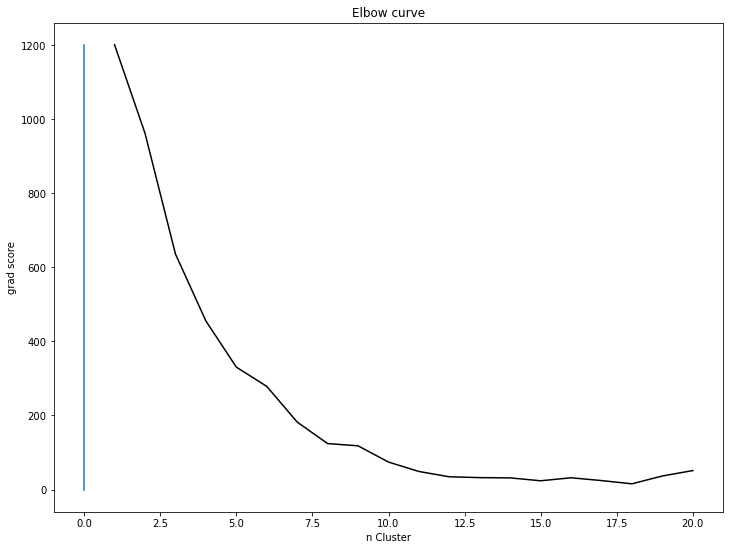

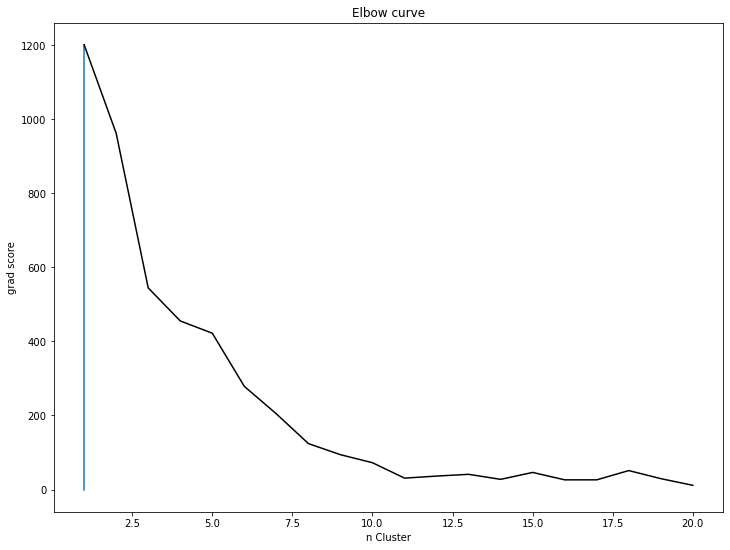

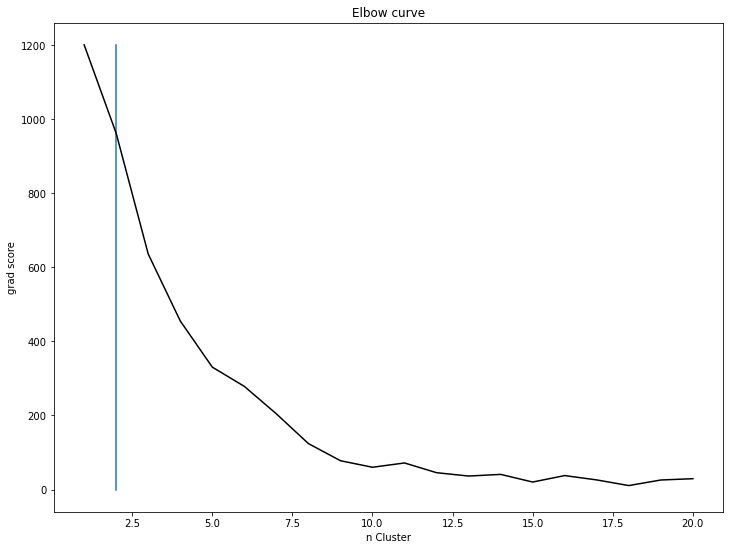

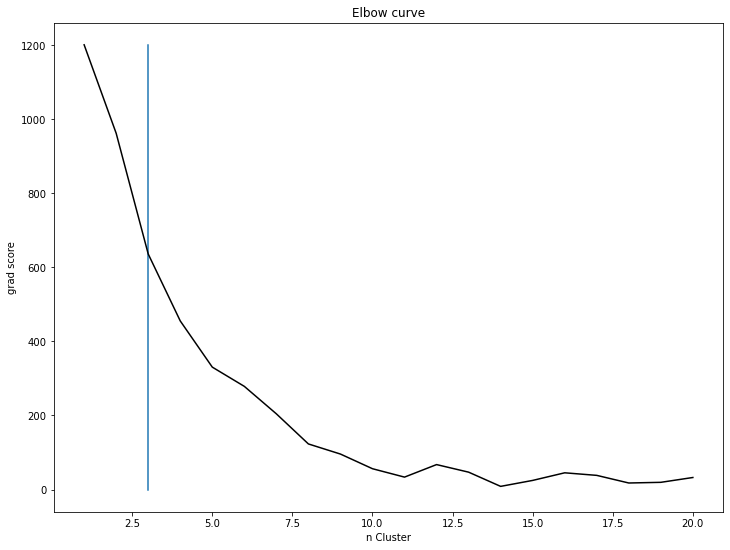

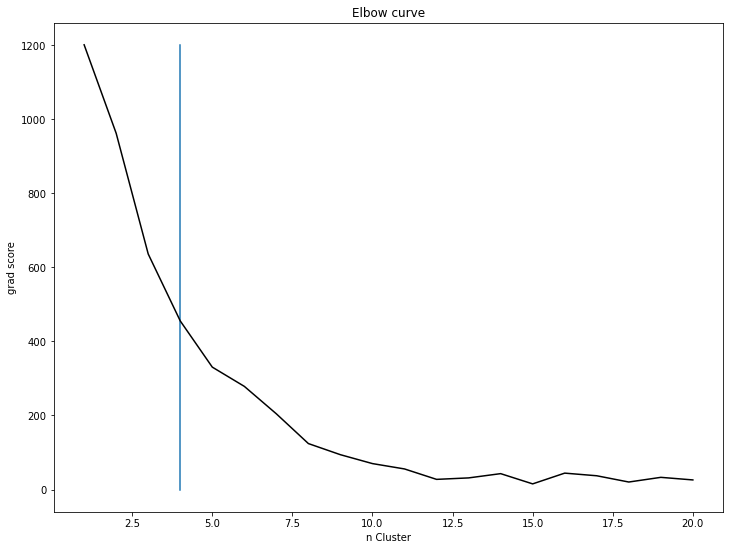

In [12]:
print([k_ellbow_analysis(dataset, i) for i in range(0, 5)])

[None, None, None]


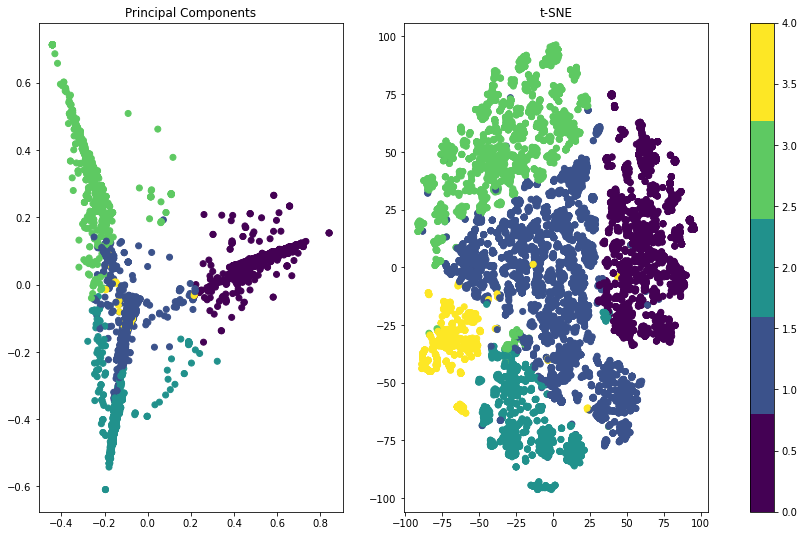

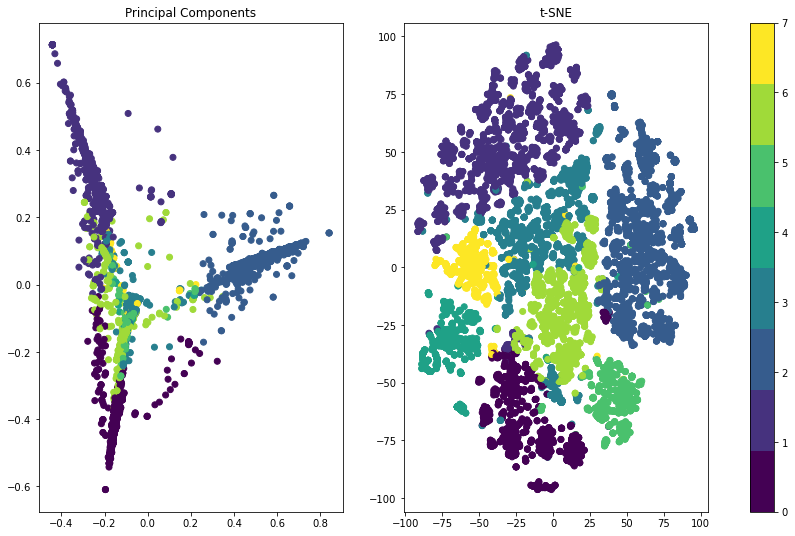

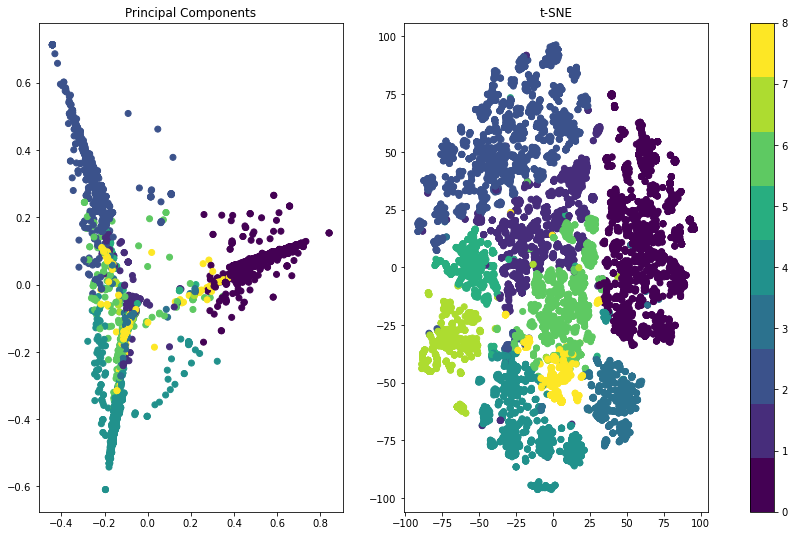

In [13]:
clusters = [5, 8, 9]
print([component_analysis(dataset, i) for i in clusters])

In [ ]:
def evaluation(data, n_c_opt):    
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    axs[0].set_title('Elbow curve')
    axs[1].set_title('Principal Components')
    axs[2].set_title('t-SNE')

    
    composition = data.iloc[:, 0:68]
        
    #k elbow plot
    k_elbow = []
    for E in range(1,21):
        kmeans = KMeans(n_clusters=E)
        kmeans.fit(composition)
        score = kmeans.score(composition)
        k_elbow.append(score)

    axs[0].set_xlabel('n Cluster')
    axs[0].set_ylabel('grad score')
    axs[0].plot([n_c_opt, n_c_opt], [0, np.max(np.gradient(k_elbow))])
    axs[0].plot(range(1, 21), np.gradient(k_elbow), 'k')
        
    #pca
    cluster = KMeans(n_clusters=n_c_opt)
    cluster.fit(composition)
    cluster_predictions = cluster.predict(composition)

    pca = PCA(n_components=2)
    reducer_01 = pca.fit_transform(composition)

    tsne = TSNE(n_components=2, random_state=42, init='pca')
    reducer_02 = tsne.fit_transform(composition)

    plot1 = axs[1].scatter(reducer_01[:, 0], reducer_01[:, 1], s=1,
                            c=cluster_predictions, cmap=plt.cm.get_cmap('viridis', n_c_opt))
    plot2 = axs[2].scatter(reducer_02[:, 0], reducer_02[:, 1], s=1,
                            c=cluster_predictions, cmap=plt.cm.get_cmap('viridis', n_c_opt))
    fig.colorbar(plot2, ax=axs)
    #fig.savefig("./images/MP_exp_pca.png")
    fig.show()

In [ ]:
evaluation(MP_data, 5)